# Chapter 14

In [1]:
from functools import partial
from pathlib import Path
from time import strftime

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

plt.style.use("dark_background")
tf.config.list_physical_devices("GPU")

2025-03-16 14:06:44.786111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 14:06:45.307613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]

1. A CNN uses far fewer parameters than a fully connected network which means they are more computationally efficient for training & inference. For example, for a typical iphone picture of shape (4032, 3024, 3), a single fully connected layer of 100 neurons (probably not enough) would have $$(4032 \times 3024 \times 3\ + 1)\times 100 = 3,657,830,500$$ trainable parameters. Because a single filter uses the same weights over an entire image, it can learn patterns that are invariant to translations.

2.  Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels: 

    a. What is the total number of parameters in the CNN?

    - Each filter is going to have $3 \times 3 \times \#channels + 1$. 
    
    - This is 28 for the first layer, 901 for the second, and 1,801 for the third.

    - Since there are 100 filters in the first layer, 200 in the next, and 400 in the third layer, we have a total of:$$28 \times 100 + 901 \times 200 + 1,801 \times 400 = 903,400 \ \text{parameters.}$$

    b. If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance?

    - During inference the RAM occupied by one layer can be released as soon as the next layer has been computed.
    
    - Therefore, the total RAM needed to make predictions is as much RAM as required by two consecutive layers.

    - Because padding is set to "same" and stride is 2, the output of each layer will be half the size of its input (rounding up), $$(200, \ 300, \ 3) \rightarrow (100, \ 150, \ 100) \rightarrow (50, \ 75, \ 200) \rightarrow (25, \ 38, \ 400)$$

    - The first two layers have the largest outputs so the network will need at least enough RAM to hold the outputs of these layers, i.e. $$(100 \times 150 \times 100 + 50 \times 75 \times 200) \times 32 = 72,000,000 \ \text{bits},$$ or 9 MB.

    - The model itself also needs to be kept in RAM, so that's another $903,400 \times 32 = 28,908,800 \ \text{bits},$ or 3.61 MB.

    - This gives a total of 12.61 MB.

    c. What about when training on a mini-batch of 50 images?

    - The reverse pass of backpropagation requires all the intermediative values computed during the forward pass. so 
    
    - So the total RAM needed is at least the total amount of RAM required by all layers: $$50 \times 32 \times (100 \times 150 \times 100 + 50 \times 75 \times 200 + 25 \times 38 \times 400) = 4,208,000,000 \ \text{bits},$$ or 526 MB.

    - Plus the RAM needed for the model: 3.61 MB.

    - Plus the RAM needed for the input images: $50 \times 32 \times 200 \times 300 \times 3 = 288,000,000 \ \text{bits}$, or 36 MB.

    - This totals 565.61 MB (not including memory required to store the gradients).

In [2]:
Conv = partial(keras.layers.Conv2D, kernel_size=(3, 3), padding="same", strides=2)

model = keras.Sequential(
    [
        keras.layers.Input(shape=(200, 300, 3)),
        Conv(filters=100),
        Conv(filters=200),
        Conv(filters=400),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 150, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 75, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 38, 400)    │       720,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 903,400 (3.45 MB)

 Trainable params: 903,400 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

3. If your GPU runs out of memory during training you can try:

    - reduce the mini-batch size,

    - use 16-bit floats instead of 32-bit,

    - reduce the dimensionality by increasing the stride,

    - reduce the number of layers, or

    - distribute the CNN across multiple devices.
 
4. **Max pooling layer vs. convolutional layer with stride:** both methods shrink the image, reducing computational & memory load (and also reduce number of parameters in subsequent layers, reducing overfitting). A max pooling layer however introduces translation, scale, and rotational invariance to the model, which is ideal for tasks like classification
 
5. **Local response normalization:** a competitive normalization layer that should be added after convolutional layers to improve generalization. The most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps. This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features.
 
6. Main innovations of CNN architectures compared to LeNet-5 (year architecture won the ILSVRC ImageNet challenge in brackets):

    - **AlexNet (2012):** Was much deeper than LeNet-5 and stacked convolutional layers directly on-top of each other (rather than separated by pooling layers). To reduce overfitting, it used data augmentation and dropout on the fully connected layers. It also used **local response normalization (LRN)**, in which the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps, encouraging the feature maps to explore a wider range of features.

    - **GoogleLeNet (2014):** Again, the network was much deeper than previous CNNs. Although it had 10 times fewer parameters than AlexNet because it used **inception modules**. These make use of parallel convolutional layers (whose outputs are concatenated along the depth dimension) of different kernel sizes, allowing them to capture patterns of different scales. Convolutional layers with kernel size of 1 are used to reduce the depth of the image, cutting parameters and computational cost.

    - **ResNet (2015):** Once again this network was deeper, but made use **skip connections** and the idea of *residual learning* (i.e. initializing the network to the identity as opposed to just outputting zero is closer to the target function). Skip connections (or **residual units**) also allow the signal from back propagation to more easily flow down the network.

    - **Xception:** Merged the ideas of GoogLeNet and ResNet, but replacing inception modules with a **depthwise separable convolution layer** (or separable convolution layer for short) which makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. It first applies one spatial filter to each input channel, then it applies a regular convolutional layer with kernel size of 1, which finds cross-channel patterns.

    - **SENet (2017):** a.k.a. *Squeeze-and-Excitation Network*, extends and boosts the performance of existing architectures such as inception networks and ResNets (they become *SE-Inception* and *SE-ResNet* respectively). It does this by adding a small neural network, called an **SE block**) to every inception module or residual unit, this small neural network focusses exclusively on the depth dimension and learns which features are usually most active together. It then uses this information to *recalibrate* the feature maps.

    - **EfficientNet:** First found a good architecture for a scaled-down version of ImageNet using neural architecture search, then used **compound scaling** to jointly increase the depth, width, and resolution in a principled way.

7. A fully convolutional network can be created by replacing the dense layers at the top of a CNN with convolutional layers. The new convolutional layers should have as many features as neurons in the old dense layers and a kernel size that matches the image size of the previous convolutional layer with padding set to valid. The FCN is equivalent to the CNN except it can now process larger images and will output a result as if the old CNN swept across the larger image, but much more efficiently as it only needs to see the input once!

8. Semantic segmentation is difficult because images lose their spatial resolution as they pass through a regular CNN (due to pooling layers & convolutional layers with stride). One solution is to use transposed convolutional layers (like a regular convolutional layer with a fractional stride) to upsample the image.

9. Build a CNN to get the highest possible accuracy on MNIST hand written digits dataset: [Kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/leaderboard) & [my code](https://github.com/edwardbickerton/Kaggle-competitions/blob/main/digit-recognizer.ipynb).

## 10. Use transfer learning for large image classification

a. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).

In [3]:
DATA_DIR = Path("datasets/14/my_image_data")
class_labels = ("dog", "hiking", "sea", "skiing")


def parse_image(image_path, get_label=True):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    if get_label:
        label = tf.strings.split(image_path, "/")[-1]
        label = tf.strings.split(label)[0]
        label = tf.where(tf.equal(class_labels, label))[0, 0]
        return image, label

    return image


dataset = (
    tf.data.Dataset.list_files(
        [str(file_path) for file_path in DATA_DIR.rglob("*.jpeg")],
        shuffle=True,
    )
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(100)
)

b. Split it into a training set, a validation set, and a test set.

In [4]:
test_set = dataset.take(112)
val_set = dataset.skip(112).take(112)
train_set = dataset.skip(224)

c. Build the input pipeline, apply the appropriate preprocessing operations, and optionally add data augmentation.

In [5]:
class DataAugmentationLayer(keras.Layer):
    def __init__(
        self,
        fill_value=-1.0,
        value_range=(-1.0, 1.0),
        zoom_factor=0.1,
        translation_factor=0.1,
        rotation_factor=0.05,
        brightness_factor=0.25,
        flip_mode="horizontal",
    ):
        super().__init__()
        self.layers = [
            keras.layers.RandomBrightness(brightness_factor, value_range=value_range),
            keras.layers.RandomFlip(mode=flip_mode),
            keras.layers.RandomZoom(
                height_factor=zoom_factor,
                width_factor=zoom_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
            keras.layers.RandomTranslation(
                height_factor=translation_factor,
                width_factor=translation_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
            keras.layers.RandomRotation(
                rotation_factor,
                fill_mode="constant",
                fill_value=fill_value,
            ),
        ]

    def call(self, inputs, training=False):
        for layer in self.layers:
            inputs = layer(inputs, training=training)
        return inputs

In [6]:
class PreprocessLayer(keras.Layer):
    def __init__(self, scale=1.0 / 127.5, offset=-1.0, height_width=480):
        super().__init__()
        self.rescaling_layer = keras.layers.Rescaling(scale=scale, offset=offset)
        self.data_augmentation_layer = DataAugmentationLayer()
        self.resize_layer = keras.layers.Resizing(
            height_width,
            height_width,
            crop_to_aspect_ratio=True,
        )

    def call(self, inputs, training=False):
        inputs = self.rescaling_layer(inputs)
        inputs = self.data_augmentation_layer(inputs, training=training)
        inputs = self.resize_layer(inputs)
        return inputs

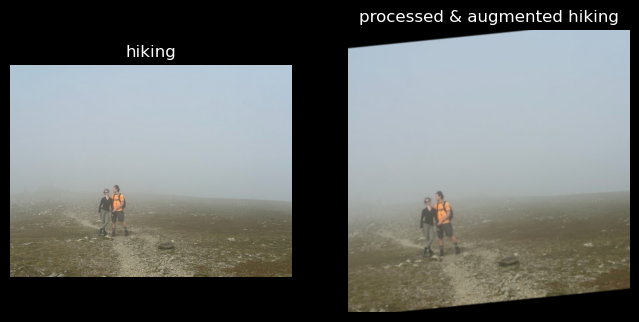

Shape: (480, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.958647))


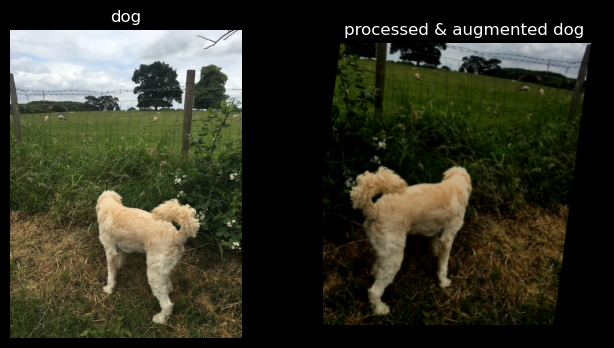

Shape: (640, 481, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.6466893))


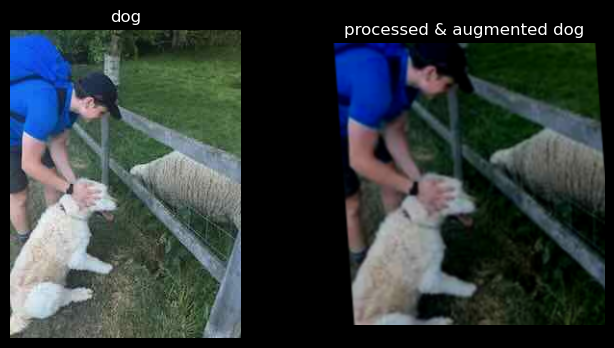

Shape: (320, 240, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.5557968))


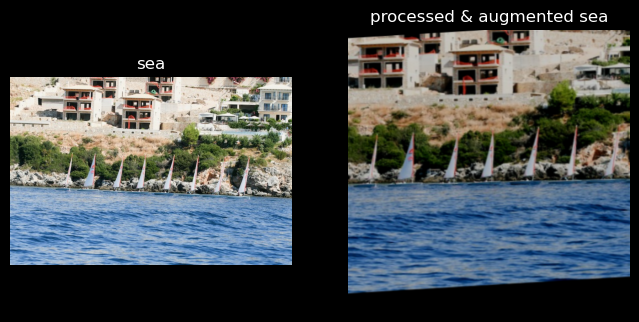

Shape: (427, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.58364093))


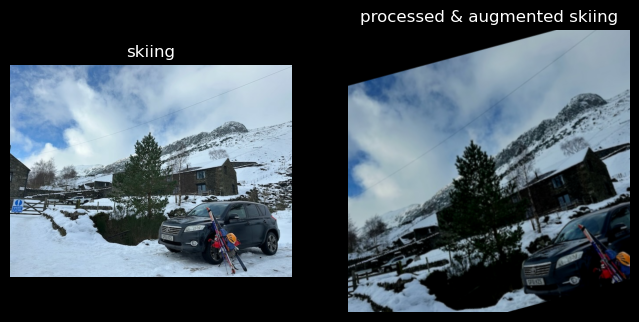

Shape: (480, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.67168087))


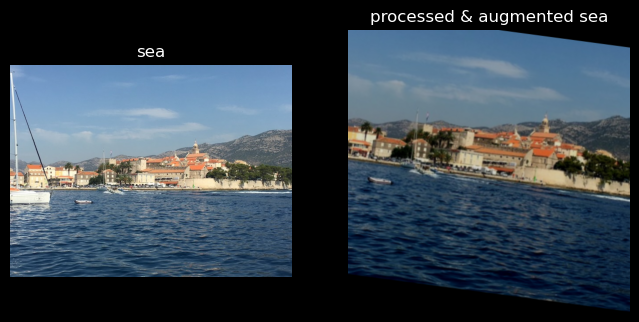

Shape: (481, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.65878))


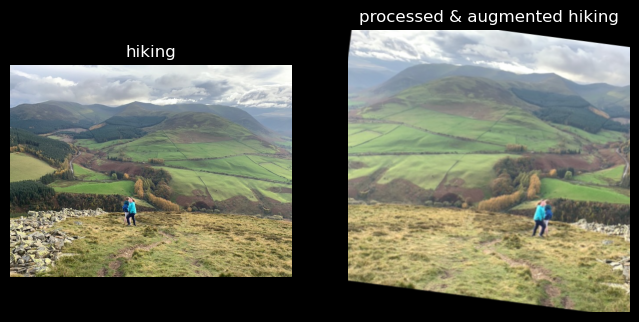

Shape: (481, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(1.0))


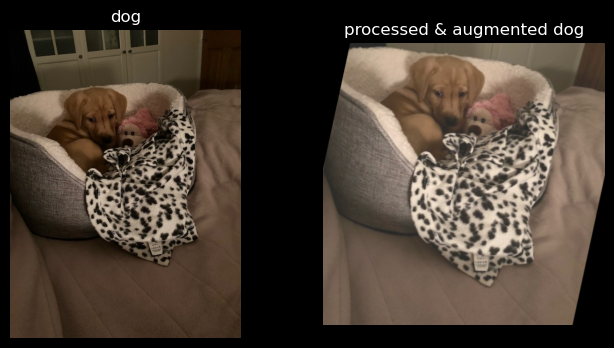

Shape: (640, 480, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(216)) --> (np.float32(-1.0), np.float32(0.95444936))


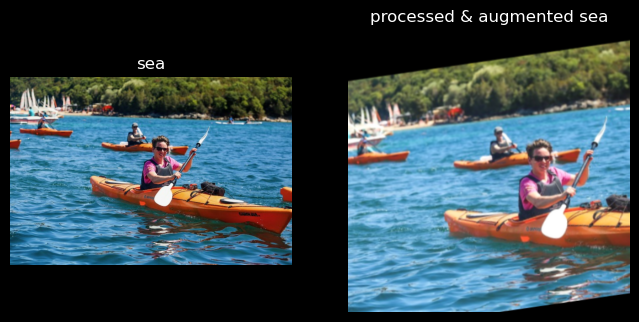

Shape: (427, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(1.0))


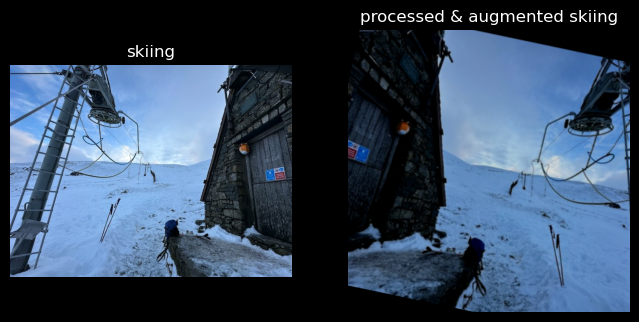

Shape: (480, 640, 3) --> (480, 480, 3)
Scale: (np.uint8(0), np.uint8(255)) --> (np.float32(-1.0), np.float32(0.70013356))


2025-03-16 14:07:00.687356: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
sample = train_set.take(10)
preprocess_layer = PreprocessLayer()


def plot(image, title, ax=None, scale=(0, 255)):
    ax = plt.gca() if ax is None else ax

    if scale == (0, 255):
        plot_rescaling_layer = keras.layers.Rescaling(scale=1.0 / 255)
    if scale == (-1, 1):
        plot_rescaling_layer = keras.layers.Rescaling(scale=0.5, offset=0.5)

    image_copy = tf.identity(image)
    scaled_image = plot_rescaling_layer(image_copy)

    ax.imshow(scaled_image, vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")


for image, label in sample:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

    plot(image, class_labels[label], axs[0])

    original_shape = image.shape
    original_scale = (image.numpy().min(), image.numpy().max())

    image = preprocess_layer(image, training=True)

    plot(image, f"processed & augmented {class_labels[label]}", axs[1], scale=(-1, 1))
    plt.show()
    print(
        f"Shape: {original_shape} --> {image.shape}",
        f"Scale: {original_scale} --> {(image.numpy().min(), image.numpy().max())}",
        sep="\n",
    )

In [8]:
test_set = (
    test_set.map(lambda image, label: (preprocess_layer(image), label))
    .batch(32)
    .cache()
)
val_set = (
    val_set.map(lambda image, label: (preprocess_layer(image), label)).batch(32).cache()
)
train_set = (
    train_set.cache()
    .shuffle(100)
    .map(
        lambda image, label: (preprocess_layer(image, training=True), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

d. Fine-tune a pretrained model on this dataset.

In [9]:
base_model = keras.applications.EfficientNetV2M(
    include_top=False, weights="imagenet", include_preprocessing=False
)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(class_labels), activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
    metrics=["accuracy"],
)

In [10]:
def get_run_logdir(root_logdir):
    return str(Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S"))


history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=5,
    callbacks=[
        keras.callbacks.TensorBoard(get_run_logdir("logs/14/")),
    ],
)

Epoch 1/5


KeyboardInterrupt: 

In [11]:
model.evaluate(test_set)

2025-03-16 14:07:25.087298: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 88473856 bytes after encountering the first element of size 88473856 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
I0000 00:00:1742134045.230510    3988 service.cc:148] XLA service 0x7f113c039770 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742134045.230930    3988 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1742134045.449359    3988 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/4 ━━━━━━━━━━━━━━━━━━━━ 59s 20s/step - accuracy: 0.2188 - loss: 1.3629

KeyboardInterrupt: 

2025-03-16 14:07:51.747936: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

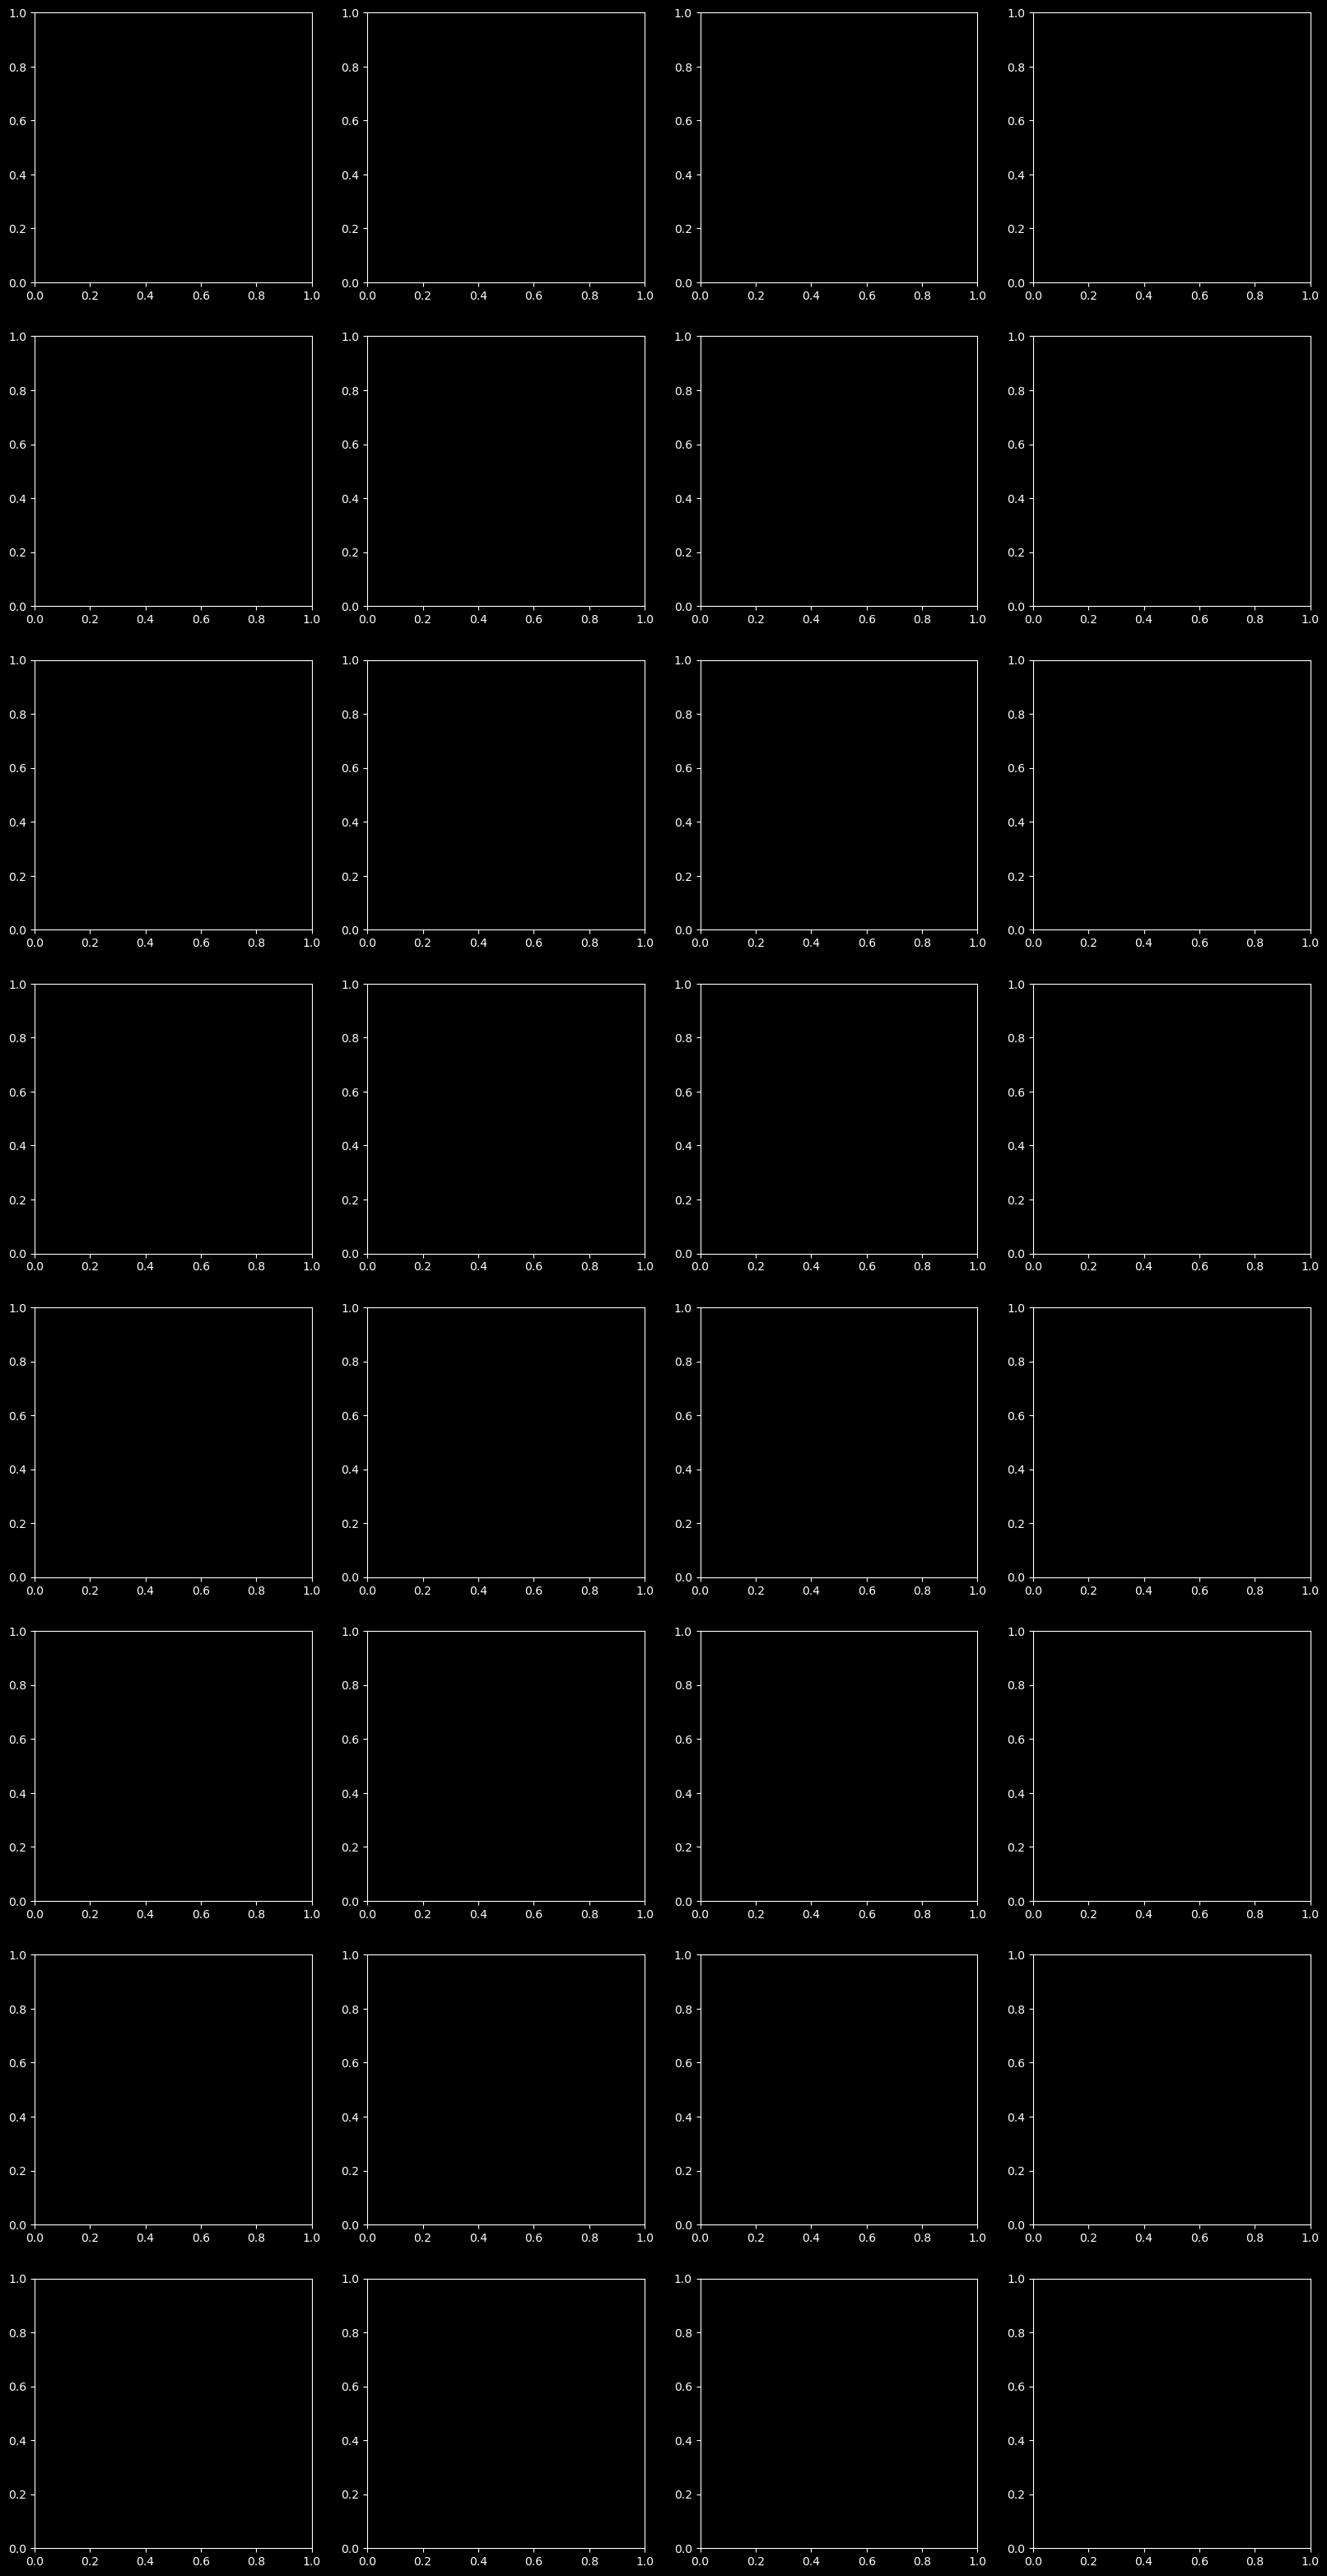

In [12]:
fig, axs = plt.subplots(ncols=4, nrows=8, figsize=(20, 40))
for image_batch, label_batch in test_set.take(1):
    predictions = model.predict(image_batch).argmax(-1)
    for image, label, prediction, ax in zip(
        image_batch, label_batch, predictions, axs.flatten()
    ):
        title = f"Predicted: {class_labels[prediction]}, Actual: {class_labels[label]}"
        plot(image, title, scale=(-1, 1), ax=ax)
plt.show()

## 11. TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto)

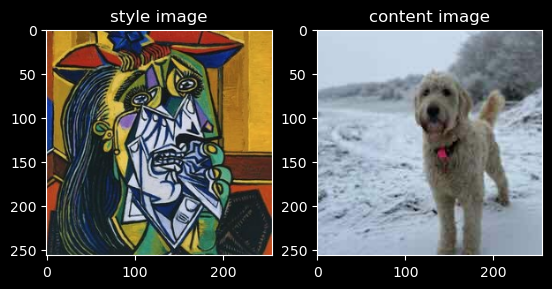

In [ ]:
DATA_DIR = Path("datasets/14/style_transfer")

resize_layer = keras.layers.Resizing(256, 256, crop_to_aspect_ratio=True)

style_image = resize_layer(parse_image(str(DATA_DIR / "style.jpeg"), get_label=False))
content_image = resize_layer(
    parse_image(str(DATA_DIR / "content.jpeg"), get_label=False)
)

fig, axs = plt.subplots(1, 2)
plot(style_image, "style image", ax=axs[0])
plot(content_image, "content image", ax=axs[1])
for ax in axs:
    ax.axis("on")
plt.show()

In [ ]:
keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
).summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
content_layers = ["block5_conv2"]

style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()

        self.base_model = keras.applications.VGG19(
            include_top=False, weights="imagenet"
        )
        self.base_model.trainable = False

        self.style_layers = style_layers
        self.content_layers = content_layers

        def layer_output_model(layer_names):
            outputs = [base_model.get_layer(name).output for name in layer_names]
            model = tf.keras.Model([base_model.input], outputs)
            return model

        self.style_model = layer_output_model(style_layers)
        self.content_model = layer_output_model(content_layers)

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / (num_locations)

    def call(self, inputs):
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)

        style_outputs = self.style_model(preprocessed_input)
        content_outputs = self.content_model(preprocessed_input)

        style_outputs = [
            self.gram_matrix(style_output) for style_output in style_outputs
        ]

        content_dict = {
            content_name: value
            for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name: value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {"content": content_dict, "style": style_dict}


style_content_extractor = StyleContentModel(style_layers, content_layers)
results = style_content_extractor(
    tf.constant(tf.reshape(content_image, (1, 256, 256, 3)))
)
print("Styles:")
for name, output in sorted(results["style"].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results["content"].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_813']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


tf.Tensor(
[[[[  0.          44.73873     23.584696   ...   0.
     24.060345     0.        ]
   [  0.          72.055084    73.52932    ...   0.
    173.37868    123.40806   ]
   [  0.          72.055084    73.52932    ...   0.
    173.37868    123.40806   ]
   ...
   [  0.           0.         110.083244   ...   0.
    289.552      225.4784    ]
   [  0.           0.         112.41923    ...   0.
    292.11484    231.59645   ]
   [ 11.033625     0.         176.81024    ...   0.
    482.94254    487.12146   ]]

  [[  0.          59.844982     9.539574   ...   0.
      0.           0.        ]
   [  0.8444413   96.280266    69.05447    ...   0.
      1.6152972   23.821564  ]
   [  0.8444413   96.280266    69.05447    ...   0.
      1.6152972   23.821564  ]
   ...
   [  0.           0.         105.27462    ...   0.
     18.126442    93.97929   ]
   [  3.8650339    0.         104.03788    ...   0.
      6.3517094   89.85046   ]
   [411.03622      0.         203.7088     ...   0.
    362.

In [64]:
StyleContentModel.gram_matrix(results[0][0])

tf.Tensor(
[[[[  0.          44.73873     23.584696   ...   0.
     24.060345     0.        ]
   [  0.          72.055084    73.52932    ...   0.
    173.37868    123.40806   ]
   [  0.          72.055084    73.52932    ...   0.
    173.37868    123.40806   ]
   ...
   [  0.           0.         110.083244   ...   0.
    289.552      225.4784    ]
   [  0.           0.         112.41923    ...   0.
    292.11484    231.59645   ]
   [ 11.033625     0.         176.81024    ...   0.
    482.94254    487.12146   ]]

  [[  0.          59.844982     9.539574   ...   0.
      0.           0.        ]
   [  0.8444413   96.280266    69.05447    ...   0.
      1.6152972   23.821564  ]
   [  0.8444413   96.280266    69.05447    ...   0.
      1.6152972   23.821564  ]
   ...
   [  0.           0.         105.27462    ...   0.
     18.126442    93.97929   ]
   [  3.8650339    0.         104.03788    ...   0.
      6.3517094   89.85046   ]
   [411.03622      0.         203.7088     ...   0.
    362.

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[4655.302  , 1229.3192 , 2066.1265 , ...,    0.     ,
         1967.3048 , 3629.4155 ],
        [1229.3192 , 6805.5957 , 5577.0054 , ...,    0.     ,
          973.44324, 2841.9326 ],
        [2066.1265 , 5577.0054 , 5717.794  , ...,    0.     ,
         1742.7522 , 4123.635  ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [1967.3048 ,  973.44324, 1742.7522 , ...,    0.     ,
         2880.1658 , 3547.062  ],
        [3629.4155 , 2841.9326 , 4123.635  , ...,    0.     ,
         3547.062  , 5871.1064 ]]], shape=(1, 64, 64), dtype=float32)>

In [56]:
StyleContentModel.gram_matrix(test)

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[4655.302  , 1229.3192 , 2066.1265 , ...,    0.     ,
         1967.3048 , 3629.4155 ],
        [1229.3192 , 6805.5957 , 5577.0054 , ...,    0.     ,
          973.44324, 2841.9326 ],
        [2066.1265 , 5577.0054 , 5717.794  , ...,    0.     ,
         1742.7522 , 4123.635  ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [1967.3048 ,  973.44324, 1742.7522 , ...,    0.     ,
         2880.1658 , 3547.062  ],
        [3629.4155 , 2841.9326 , 4123.635  , ...,    0.     ,
         3547.062  , 5871.1064 ]]], shape=(1, 64, 64), dtype=float32)>